In [1]:
import h5py as h5
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle
import sys
sys.path.append(os.path.expanduser("~/TMPredictor/survival_tm/auton-survival"))
from auton_survival.preprocessing import Scaler
import optuna
from sklearn.model_selection import ParameterGrid
#sys.path.append('/projects/EKOLEMEN/survival_tm/train_models/auton-survival')
sys.path.append(os.path.expanduser("~/TMPredictor/survival_tm/auton-survival"))
from sklearn.model_selection import ParameterGrid
from auton_survival.estimators import SurvivalModel
from auton_survival.metrics import survival_regression_metric
from auton_survival.models.dsm import DeepSurvivalMachines
from sksurv.metrics import concordance_index_ipcw, brier_score, cumulative_dynamic_auc
from sklearn.decomposition import PCA

/home/hf8585/.conda/envs/torch/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


CREATE MAIN PREPROCESSED DATABASE

In [2]:
shots = np.load('/projects/EKOLEMEN/survival_tm/shots.npy')
tm_shots = np.load('/projects/EKOLEMEN/survival_tm/tm_shots.npy')
st_shots = np.load('/projects/EKOLEMEN/survival_tm/st_shots.npy')

def load_data(data_type):
    with open(f'/projects/EKOLEMEN/survival_tm/formatted_labels/{data_type}.pkl', 'rb') as f:
        data = pickle.load(f)
    
    return data['x'], data['t'], data['e']

# Don't want whole dataset right now so 0.5 factor to reduce
n = len(shots)

tr_size = int(n*0.80)
vl_size = int(n*0.10)
te_size = int(n*0.10)

train_shots = shots[:tr_size]
test_shots = shots[-te_size:]
valid_shots = shots[tr_size:tr_size+vl_size]

x_train, t_train, e_train = load_data('train')
x_test,  t_test,  e_test  = load_data('test')
x_valid, t_valid, e_valid = load_data('valid')

# Get inds for time <600ms
# is this needed? Not sure.
'''inds = np.where(t_train < 600)[0]

x_train = x_train[inds]
t_train = t_train[inds]
e_train = e_train[inds]'''

tm_inds = np.where(e_train == 1)[0]
st_inds = np.where(e_train == 0)[0]
new_st_inds = np.random.choice(st_inds, size=len(tm_inds), replace=False)
combined_inds = np.concatenate((tm_inds, new_st_inds))
sorted_combined_inds = np.sort(combined_inds)

x_train = x_train[sorted_combined_inds]
t_train = t_train[sorted_combined_inds]
e_train = e_train[sorted_combined_inds]

'''x_train = np.concatenate((x_train[tm_inds], x_train[new_st_inds]), axis=0)
t_train = np.concatenate((t_train[tm_inds], t_train[new_st_inds]), axis=0)
e_train = np.concatenate((e_train[tm_inds], e_train[new_st_inds]), axis=0)
plt.plot(t_train[10000:11000])
# Shuffle arrays because currently all 1s followed by all 0s
p = np.random.permutation(len(t_train))
x_train = x_train[p,:]
t_train = t_train[p]
e_train = e_train[p]'''

x_train_df = pd.DataFrame(x_train)
t_train_df = pd.DataFrame(t_train)
e_train_df = pd.DataFrame(e_train)

x_valid_df = pd.DataFrame(x_valid)
t_valid_df = pd.DataFrame(t_valid)
e_valid_df = pd.DataFrame(e_valid)

x_test_df = pd.DataFrame(x_test)
t_test_df = pd.DataFrame(t_test)
e_test_df = pd.DataFrame(e_test)

outcomes_valid_df = pd.DataFrame({'time': t_valid, 'event': e_valid})

outcomes_train_df = pd.DataFrame({'time': t_train, 'event': e_train})
outcomes_test_df = pd.DataFrame({'time': t_test, 'event': e_test})
#normalize
scaler = Scaler()
transformer = scaler.fit(x_train_df)
x_train_df_normed = transformer.transform(x_train_df)
x_valid_df_normed = transformer.transform(x_valid_df)
x_test_df_normed = transformer.transform(x_test_df)

'''with open('data/x_train_df_normed.pkl', 'wb') as f:
    pickle.dump(x_train_df_normed, f)
with open('data/x_valid_df_normed.pkl', 'wb') as f:
    pickle.dump(x_valid_df_normed, f)
with open('data/x_test_df_normed.pkl', 'wb') as f:
    pickle.dump(x_test_df_normed, f)
with open('data/outcomes_valid_df.pkl', 'wb') as f:
    pickle.dump(outcomes_valid_df, f)
with open('data/outcomes_train_df.pkl', 'wb') as f:
    pickle.dump(outcomes_train_df, f)
with open('data/outcomes_test_df.pkl', 'wb') as f:
    pickle.dump(outcomes_test_df, f)'''

"with open('data/x_train_df_normed.pkl', 'wb') as f:\n    pickle.dump(x_train_df_normed, f)\nwith open('data/x_valid_df_normed.pkl', 'wb') as f:\n    pickle.dump(x_valid_df_normed, f)\nwith open('data/x_test_df_normed.pkl', 'wb') as f:\n    pickle.dump(x_test_df_normed, f)\nwith open('data/outcomes_valid_df.pkl', 'wb') as f:\n    pickle.dump(outcomes_valid_df, f)\nwith open('data/outcomes_train_df.pkl', 'wb') as f:\n    pickle.dump(outcomes_train_df, f)\nwith open('data/outcomes_test_df.pkl', 'wb') as f:\n    pickle.dump(outcomes_test_df, f)"

CREATE PCA DATABASE

"with open('data/x_valid_pca.pkl', 'wb') as f:\n    pickle.dump(x_valid_pca, f)\n"

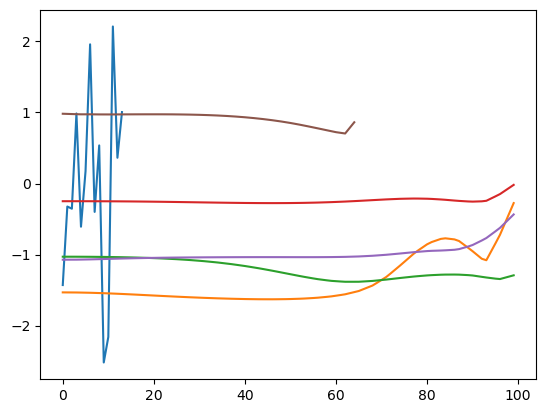

In [3]:
# separate each normalized profile
scalars = np.array(x_valid_df_normed)[:, 0:14]
te = np.array(x_valid_df_normed)[:, 14:33+14]
ti = np.array(x_valid_df_normed)[:, 33+14:66+14]
ne = np.array(x_valid_df_normed)[:, 66+14:99+14]
rot = np.array(x_valid_df_normed)[:, 99+14:132+14]
qpsi = np.array(x_valid_df_normed)[:, 132+14:165+14]

# upsample to PCS dimensions
x_old = np.linspace(0, 1, 33)
x_long = np.linspace(0, 1, 100)
x_for_q = np.linspace(0, 1, 65)
te = np.array([np.interp(x_long, x_old, te[i]) for i in range(len(te))])
ti = np.array([np.interp(x_long, x_old, ti[i]) for i in range(len(ti))])
ne = np.array([np.interp(x_long, x_old, ne[i]) for i in range(len(ne))])
rot = np.array([np.interp(x_long, x_old, rot[i]) for i in range(len(rot))])
qpsi = np.array([np.interp(x_for_q, x_old, qpsi[i]) for i in range(len(qpsi))])
plt.plot(scalars[0])
plt.plot(te[0])
plt.plot(ti[0])
plt.plot(ne[0])
plt.plot(rot[0])
plt.plot(qpsi[0])
pca = PCA(n_components=4)

# Fit PCA on the data
pca.fit(te)
te_pca = pca.transform(te)

pca.fit(ti)
ti_pca = pca.transform(ti)

pca.fit(ne)
ne_pca = pca.transform(ne)

pca.fit(rot)
rot_pca = pca.transform(rot)

pca.fit(qpsi)
qpsi_pca = pca.transform(qpsi)

x_valid_pca = pd.DataFrame(np.concatenate((scalars, te_pca, ti_pca, ne_pca, rot_pca, qpsi_pca), axis=1))

'''with open('data/x_valid_pca.pkl', 'wb') as f:
    pickle.dump(x_valid_pca, f)
'''

In [5]:
def find_peaks_in_data(data):
    peaks = []
    for i in range(1, len(data) - 1):
        if data[i-1] < data[i] > data[i+1]:
            peaks.append(i)
    return peaks

CREATE MEMORY DATABASE

In [6]:
# we give each timestep all the info from a few timesteps in the past. 

x_train_np = np.array(x_train)
t_train_np = np.array(t_train)[4:]
e_train_np = np.array(e_train)[4:]

x_valid_np = np.array(x_valid)
t_valid_np = np.array(t_valid)[4:]
e_valid_np = np.array(e_valid)[4:]

x_test_np = np.array(x_test)
t_test_np = np.array(t_test)[4:]
e_test_np = np.array(e_test)[4:]

outcomes_valid_memory = pd.DataFrame({'time': t_valid_np, 'event': e_valid_np})
outcomes_test_memory = pd.DataFrame({'time': t_test_np, 'event': e_test_np})
outcomes_train_memory = pd.DataFrame({'time': t_train_np, 'event': e_train_np})

# make the state of each timestep contain 5 timesteps of data
x_valid_memory = np.array([x_valid_np[i-4:i+1].flatten() for i in range(4, len(x_valid_np))])
x_test_memory = np.array([x_test_np[i-4:i+1].flatten() for i in range(4, len(x_test_np))])
x_train_memory = np.array([x_train_np[i-4:i+1].flatten() for i in range(4, len(x_train_np))])

# remove the first 4 timesteps of each shot from the dataset. This is so that data from the previous shot isn't saved in the current shot
train_peaks = np.array(find_peaks_in_data(np.array(outcomes_train_memory['time'])))
valid_peaks = np.array(find_peaks_in_data(np.array(outcomes_valid_memory['time'])))
test_peaks = np.array(find_peaks_in_data(np.array(outcomes_test_memory['time'])))
new_train_peaks = np.sort(np.concatenate((train_peaks, train_peaks+1, train_peaks+2, train_peaks+3)))
new_valid_peaks = np.sort(np.concatenate((valid_peaks, valid_peaks+1, valid_peaks+2, valid_peaks+3)))
new_test_peaks = np.sort(np.concatenate((test_peaks, test_peaks+1, test_peaks+2, test_peaks+3)))
x_valid_memory = pd.DataFrame(np.delete(x_valid_memory, new_valid_peaks, axis=0))
x_test_memory = pd.DataFrame(np.delete(x_test_memory, new_test_peaks, axis=0))
x_train_memory = pd.DataFrame(np.delete(x_train_memory, new_train_peaks, axis=0))

# normalize
scaler = Scaler()
transformer = scaler.fit(x_train_memory)
x_train_memory_normed = transformer.transform(x_train_memory)
x_valid_memory_normed = transformer.transform(x_valid_memory)
x_test_memory_normed = transformer.transform(x_test_memory)

'''with open('data/x_valid_memory_normed.pkl', 'wb') as f:
    pickle.dump(x_valid_memory_normed, f)
with open('data/x_test_memory_normed.pkl', 'wb') as f:
    pickle.dump(x_test_memory_normed, f)
with open('data/x_train_memory_normed.pkl', 'wb') as f:
    pickle.dump(x_train_memory_normed, f)
with open('data/outcomes_valid_memory.pkl', 'wb') as f:
    pickle.dump(outcomes_valid_memory, f)
with open('data/outcomes_train_memory.pkl', 'wb') as f:
    pickle.dump(outcomes_train_memory, f)
with open('data/outcomes_test_memory.pkl', 'wb') as f:
    pickle.dump(outcomes_test_memory, f)'''

"with open('data/x_valid_memory_normed.pkl', 'wb') as f:\n    pickle.dump(x_valid_memory_normed, f)\nwith open('data/x_test_memory_normed.pkl', 'wb') as f:\n    pickle.dump(x_test_memory_normed, f)\nwith open('data/x_train_memory_normed.pkl', 'wb') as f:\n    pickle.dump(x_train_memory_normed, f)\nwith open('data/outcomes_valid_memory.pkl', 'wb') as f:\n    pickle.dump(outcomes_valid_memory, f)\nwith open('data/outcomes_train_memory.pkl', 'wb') as f:\n    pickle.dump(outcomes_train_memory, f)\nwith open('data/outcomes_test_memory.pkl', 'wb') as f:\n    pickle.dump(outcomes_test_memory, f)"

CREATE FUTURE ACTUATORS DATABASE. SAME LOGIC AS ABOVE, BUT ONLY SAVING SCALARS DATA

In [7]:
signals = ['pinj', 'tinj', 'betan_EFIT01', 'qmin_EFIT01', 'ech_pwr_total', 'ip', 'bt', 'li_EFIT01', 'aminor_EFIT01', 
          'rmaxis_EFIT01', 'tribot_EFIT01', 'tritop_EFIT01', 'kappa_EFIT01', 'volume_EFIT01']

# we give each timestep all the info from a few timesteps in the past. 

x_train_np = np.array(x_train)
t_train_np = np.array(t_train)[:-4]
e_train_np = np.array(e_train)[:-4]

x_valid_np = np.array(x_valid)
t_valid_np = np.array(t_valid)[:-4]
e_valid_np = np.array(e_valid)[:-4]

x_test_np = np.array(x_test)
t_test_np = np.array(t_test)[:-4]
e_test_np = np.array(e_test)[:-4]

outcomes_valid_future = pd.DataFrame({'time': t_valid_np, 'event': e_valid_np})
outcomes_test_future = pd.DataFrame({'time': t_test_np, 'event': e_test_np})
outcomes_train_future = pd.DataFrame({'time': t_train_np, 'event': e_train_np})

# we keep the present and 4 in the future
x_valid_future = pd.DataFrame([np.concatenate((x_valid_np[i:i+5, 0:len(signals)].flatten(), x_valid_np[i, len(signals):])) for i in range(len(x_valid_np)-4)])
x_test_future = pd.DataFrame([np.concatenate((x_test_np[i:i+5, 0:len(signals)].flatten(), x_test_np[i, len(signals):])) for i in range(len(x_test_np)-4)])
x_train_future = pd.DataFrame([np.concatenate((x_train_np[i:i+5, 0:len(signals)].flatten(), x_train_np[i, len(signals):])) for i in range(len(x_train_np)-4)])

train_peaks = np.array(find_peaks_in_data(np.array(outcomes_train_future['time'])))
valid_peaks = np.array(find_peaks_in_data(np.array(outcomes_valid_future['time'])))
test_peaks = np.array(find_peaks_in_data(np.array(outcomes_test_future['time'])))

new_train_peaks = np.sort(np.concatenate((train_peaks-1, train_peaks-2, train_peaks-3, train_peaks-4)))
new_valid_peaks = np.sort(np.concatenate((valid_peaks-1, valid_peaks-2, valid_peaks-3, valid_peaks-4)))
new_test_peaks = np.sort(np.concatenate((test_peaks-1, test_peaks-2, test_peaks-3, test_peaks-4)))

x_valid_future = pd.DataFrame(np.delete(x_valid_future, new_valid_peaks, axis=0))
x_test_future = pd.DataFrame(np.delete(x_test_future, new_test_peaks, axis=0))
x_train_future = pd.DataFrame(np.delete(x_train_future, new_train_peaks, axis=0))

scaler = Scaler()
transformer = scaler.fit(x_train_future)
x_train_future_normed = transformer.transform(x_train_future)
x_valid_future_normed = transformer.transform(x_valid_future)
x_test_future_normed = transformer.transform(x_test_future)

'''with open('data/x_valid_future_normed.pkl', 'wb') as f:
    pickle.dump(x_valid_future_normed, f)
with open('data/x_test_future_normed.pkl', 'wb') as f:
    pickle.dump(x_test_future_normed, f)
with open('data/x_train_future_normed.pkl', 'wb') as f:
    pickle.dump(x_train_future_normed, f)
with open('data/outcomes_valid_future.pkl', 'wb') as f:
    pickle.dump(outcomes_valid_future, f)
with open('data/outcomes_train_future.pkl', 'wb') as f:
    pickle.dump(outcomes_train_future, f)
with open('data/outcomes_test_future.pkl', 'wb') as f:
    pickle.dump(outcomes_test_future, f)'''

"with open('data/x_valid_future_normed.pkl', 'wb') as f:\n    pickle.dump(x_valid_future_normed, f)\nwith open('data/x_test_future_normed.pkl', 'wb') as f:\n    pickle.dump(x_test_future_normed, f)\nwith open('data/x_train_future_normed.pkl', 'wb') as f:\n    pickle.dump(x_train_future_normed, f)\nwith open('data/outcomes_valid_future.pkl', 'wb') as f:\n    pickle.dump(outcomes_valid_future, f)\nwith open('data/outcomes_train_future.pkl', 'wb') as f:\n    pickle.dump(outcomes_train_future, f)\nwith open('data/outcomes_test_future.pkl', 'wb') as f:\n    pickle.dump(outcomes_test_future, f)"